In [1]:
import os
import sys

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

import h5py
import numpy as np

from sklearn.preprocessing import MinMaxScaler

tf.test.gpu_device_name()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# add src to path
sys.path.insert(0,'/content/gdrive/MyDrive/fake-faces-detector/src')
from utils.modelling_functions import *
from utils.color_space_operations import comatrix_from_image, calculate_difference_image, hist_peek_point, greycoprops_from_image

# Loading datasets

In [4]:
path = '/content/gdrive/MyDrive/masterDB/train.h5'
path_val = '/content/gdrive/MyDrive/masterDB/val.h5'
available_models = ['Xception', 'Dense', 'ScalarNN', "SVM"]
available_inputs = ['RGB', 'HCbCr', 'HSV', 'YCbCr', 'grad', 'scalars']

In [91]:
model_name = 'ScalarNN'
input = "scalars"

number_of_train_imgs = 6500
number_of_val_imgs = 1200

In [6]:
X_train = load_dataset_h5(path, 'X_train')[:number_of_train_imgs]
y_train = load_dataset_h5(path, 'y_train')[:number_of_train_imgs].reshape((-1,1))

<KeysViewHDF5 ['X_train', 'y_train']>
<KeysViewHDF5 ['X_train', 'y_train']>


In [7]:
X_val = load_dataset_h5(path_val, 'X_val')[:number_of_val_imgs]
y_val = load_dataset_h5(path_val, 'y_val')[:number_of_val_imgs].reshape((-1,1))

<KeysViewHDF5 ['X_val', 'y_val']>
<KeysViewHDF5 ['X_val', 'y_val']>


In [8]:
import typing as t
def hist_peak_point_from3D_img(np_img: np.ndarray, bins=256, hist_range=(0,255)) -> t.Tuple[float, int]:
    """Calculate histogram peek point

    Args:
        np_img (np.ndarray): input image to calculate histograms 
        bins (int, optional): number of histogram intervals. Defaults to 511.
        hist_range (tuple, optional): image pixels range. Defaults to (-255, 256).

    Returns:
        t.Tuple[float, int]: peek point coordinates (pixel value, number of occurences)
    """
    peak_points = []
    for i in range(np_img.shape[2]):
        np_hist, bins = np.histogram(np_img[i], density=True,
                                    bins=bins, range=hist_range)
        y = np_hist.max()
        idx = np.argwhere(np_hist==y)
        if len(idx)>1:
            idx = int(idx[0])
        else:
            idx = int(idx)
        
        x = int(bins[idx])
        peak_points.append(x)
        peak_points.append(y)

    return peak_points

In [9]:
def getAdditionalScalars(np_X):
    np_X_scalars = np.empty((np_X.shape[0],18))
    for i in range(np_X.shape[0]):
        np_all = all_colorspaces_from_rgb(np_X[i], type="int")
        np_HSV = np_all[:,:,3:6]
        np_YCbCr = np_all[:,:,6:]

        np_grad_HSV = calculate_difference_image(np_HSV, kernel='grad')
        np_grad_YCbCr = calculate_difference_image(np_YCbCr, kernel='grad')

        # histogram peak_points for HSV
        np_X_scalars[i,:6] = np.array(hist_peak_point_from3D_img(np_grad_HSV))
        # histogram peak_points for YCbCr
        np_X_scalars[i,6:12] = np.array(hist_peak_point_from3D_img(np_grad_YCbCr))
        # angle 0 distance 2 for H
        np_X_scalars[i,12] =  greycoprops_from_image(np_HSV[0], distances=[2], angles=[0], prop='contrast')

        # angle 0 distance 2 for S
        np_X_scalars[i,13] =  greycoprops_from_image(np_HSV[1], distances=[2], angles=[0], prop='ASM')
        
        # angle pi/2 distance 1 for V
        np_X_scalars[i,14] =  greycoprops_from_image(np_HSV[2], distances=[1], angles=[np.pi/2], prop='contrast')
        
        # angle pi/2 distance 1 for Y
        np_X_scalars[i,15] = greycoprops_from_image(np_YCbCr[0], distances=[1], angles=[np.pi/2], prop="contrast")

        # angle pi/2 distance 2 for Cb
        np_X_scalars[i,16] = greycoprops_from_image(np_YCbCr[1], distances=[2], angles=[np.pi/2], prop="contrast")

        # angle 0 distance 2 for Cr
        np_X_scalars[i,17] = greycoprops_from_image(np_YCbCr[2], distances=[2], angles=[0], prop="contrast")


    return np_X_scalars


In [88]:
def get_scalaraNN_model():
    initializer =  tf.keras.initializers.GlorotNormal()
    model = Sequential()
    model.add(Dense(18, activation='relu', kernel_initializer=initializer))
    model.add(Dense(18, activation='relu', kernel_initializer=initializer))
    model.add(Dense(18, activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())

    model.add(Dense(10, activation='relu', kernel_initializer=initializer))
    model.add(Dense(10, activation='relu', kernel_initializer=initializer))
    model.add(Dense(10, activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())

    model.add(Dense(5, activation='relu', kernel_initializer=initializer))
    model.add(Dense(5, activation='relu', kernel_initializer=initializer))
    model.add(Dense(5, activation='relu', kernel_initializer=initializer))

    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [10]:
if input == "HCbCr":
    X_train = getHCbCr(X_train)
    X_val = getHCbCr(X_val)
    
elif input == "RGB":
    pass

elif input == "HSV":
    X_train = getHSV(X_train)
    X_val = getHSV(X_val)

elif input == "YCbCr":
    X_train = getYCbCr(X_train)
    X_val = getYCbCr(X_val)

elif input == "grad":
    X_train = getGradImg(X_train)
    X_val = getGradImg(X_val)

elif input == "scalars":
    X_train = getAdditionalScalars(X_train)
    X_val = getAdditionalScalars(X_val)

elif input not in available_inputs:
    raise ValueError("Bad input specified")
else: 
    raise NotImplementedError("Specified input not implemented")

# Create model

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.applications import xception, densenet
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report


In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [13]:
def normalize_scalar_input(X_train, X_val):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    return (X_train, X_val)

In [93]:
if model_name == 'Dense':
    X_train= densenet.preprocess_input(X_train)
    X_val = densenet.preprocess_input(X_val)
    model = get_densenet()

elif model_name == 'Xception':
    X_train= xception.preprocess_input(X_train)
    X_val = xception.preprocess_input(X_val)
    model = get_xception()

elif model_name == "ScalarNN":
    X_train, X_val = normalize_scalar_input(X_train, X_val)
    model = get_scalaraNN_model()

elif model_name == "SVM":
    y_train = np.ravel(y_train)
    model = svm.SVC(kernel='rbf')

elif model_name not in available_models:
    raise ValueError("Bad model specified")
else: 
    raise NotImplementedError("Specified model not implemented")

In [94]:
if model_name== "SVM":
    model.fit(X_train, y_train)
else:
    results = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks = [early_stop], epochs=200)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/200
121/204 [================>.............] - ETA: 2s - loss: 0.6972 - accuracy: 0.4992

KeyboardInterrupt: ignored

In [57]:
y_pred = model.predict(X_val)

## Evaluation

In [83]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib

In [22]:
saving_dir = f"/content/gdrive/MyDrive/fake-faces-detector/exp/models/{model_name}_{input}"
if os.path.exists(saving_dir) == False:
    os.makedirs(saving_dir)

In [65]:
# version to print
report = classification_report(y_val, y_pred)
print(report)
# save
report = classification_report(y_val, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv(os.path.join(saving_dir, 'classification_report.csv'))


              precision    recall  f1-score   support

           0       0.57      0.55      0.56       597
           1       0.57      0.60      0.58       603

    accuracy                           0.57      1200
   macro avg       0.57      0.57      0.57      1200
weighted avg       0.57      0.57      0.57      1200



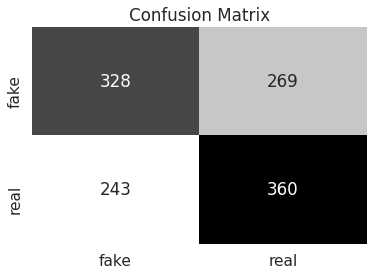

In [85]:
categories = ["fake", "real"]
# get confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
pd_conf_matrix = pd.DataFrame(conf_matrix, columns=categories, index=categories)
sn.set(font_scale=1.4) # for label size
ax = plt.axes()
sn.heatmap(pd_conf_matrix, ax = ax, annot=True, cmap='binary', fmt='g', cbar = False)
ax.set_title('Confusion Matrix')

plt.savefig(os.path.join(saving_dir, 'conf_matrix.png'))

In [86]:
# save information about Keras models
if model_name != "SVM":
    # learning history
    losses = pd.DataFrame(model.history.history)
    losses.to_csv(os.path.join(saving_dir, 'losses.csv'))
    # loss plot
    losses[['loss', 'val_loss']].plot()
    plt.savefig(os.path.join(saving_dir, 'loss.png'))
    # acc plot
    losses[['accuracy', 'val_accuracy']].plot()
    plt.savefig(os.path.join(saving_dir, 'acc.png'))
    # model save
    model.save(os.path.join(saving_dir, 'model.h5'))

else:
    joblib.dump(model, os.path.join(saving_dir, "model.sav"))
